## 1. Business Problem Statement

#### The business lacks customer-level visibility into purchasing behavior and customer value. Without segmentation, marketing efforts are generic, retention strategies are inefficient, and high-value customers are not prioritized.

## 2. Objective

#### Segment customers based on purchasing behavior and monetary value using RFM (Recency, Frequency, Monetary) analysis to enable targeted marketing, retention, and revenue optimization strategies.

## 3. Download and Load the Dataset

In [2]:
import pandas as pd

df = pd.read_excel("/Users/chinmaybhosale/code/my-projects/05-Customer-segmentation-using-RFM-analysis/online_retail_II.xlsx")


In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 4. Initial Data Understanding

In [4]:
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])

Number of rows:  525461
Number of columns:  8


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

## 5. Data Cleaning

### Removing missing customer ID's

In [8]:
df = df.dropna(subset=['Customer ID', 'Description'])

### Remove returns and invalid transactions

In [9]:
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

### Create a new 'Total Transaction Value' column 

In [10]:
df['Total Amount'] = df['Quantity'] * df['Price']

## 6. Define RFM Snapshot Date

### A snapshot date defined as one day after the last recorded transaction, ensuring accurate recency calculation.

In [11]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

## 7. RFM metric calculation

### Customer level RFM metric calculated using aggregation

In [13]:
rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "Invoice": "nunique",
    "Total Amount": "sum"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]


### Metric Definations:

### Recency: Days since last purchase

### Frequency: Number of unique purchase invoices

### Monetary: Total spending value

## 8. RFM Scoring

### Each metric scored using quartiles to standardized customer acquisiton

In [25]:
rfm["R_Score"] = pd.qcut(rfm["Recency"].rank(method="first"), 4, labels=[4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 4, labels=[1,2,3,4]).astype(int)

### A combined RFM score was created for segmentation.

In [27]:
rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str) +
    rfm["F_Score"].astype(str) +
    rfm["M_Score"].astype(str)
)

## 9. Customer Segmentation Logic

### Customers grouped into business relevant segments using RFM logic

In [32]:
def segment_customer(row):
    """
    Segment a single customer row using RFM scores.

    Parameters
    ----------
    row : pandas.Series
        Must contain 'RFM_Score' (str) and individual scores 'R_Score' and 'F_Score'
        (int or str).

    Returns
    -------
    str
        One of: 'Champions', 'Loyal Customers', 'At Risk', or 'Others'.

    Notes
    -----
    Logic:
    - 'Champions' if RFM_Score is one of the top combinations.
    - 'Loyal Customers' if high recency score and high frequency.
    - 'At Risk' if lowest recency score.
    Comparisons are written to tolerate scores represented as ints or strings.
    """
    if row["RFM_Score"] in ["444", "443", "434"]:
        return "Champions"
    elif row["R_Score"] == "4" and row["F_Score"] >= "3":
        return "Loyal Customers"
    elif row["R_Score"] == "1":
        return "At Risk"
    else:
        return "Others"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)


## 10. Segment Level Analysis

### Segment performances evaluated to understand customer distribution and revenue impact

In [33]:
rfm.groupby("Segment").agg({
    "CustomerID": "count",
    "Monetary": "sum",
    "Frequency": "mean"
})


,CustomerID,Monetary,Frequency
Segment,,,
Champions,620,4740969.833,13.653226
Others,3692,4091033.441,2.911159


## Analysis Focus:

### Customer count per segment

### Revenue contribution

### Average purchase frequency

## 11. Visualizations

### Bar chart: Customers by segment

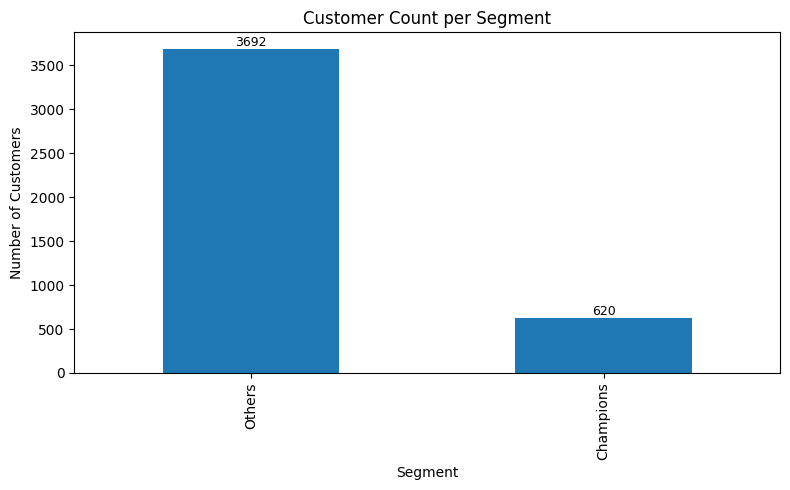

In [40]:
import matplotlib.pyplot as plt

segment_counts = rfm['Segment'].value_counts()

fig, ax = plt.subplots(figsize=(8,5))
segment_counts.plot(kind='bar', ax=ax, color='C0')
ax.set_title('Customer Count per Segment')
ax.set_xlabel('Segment')
ax.set_ylabel('Number of Customers')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

### Pie chart: Revenue contribution by segment

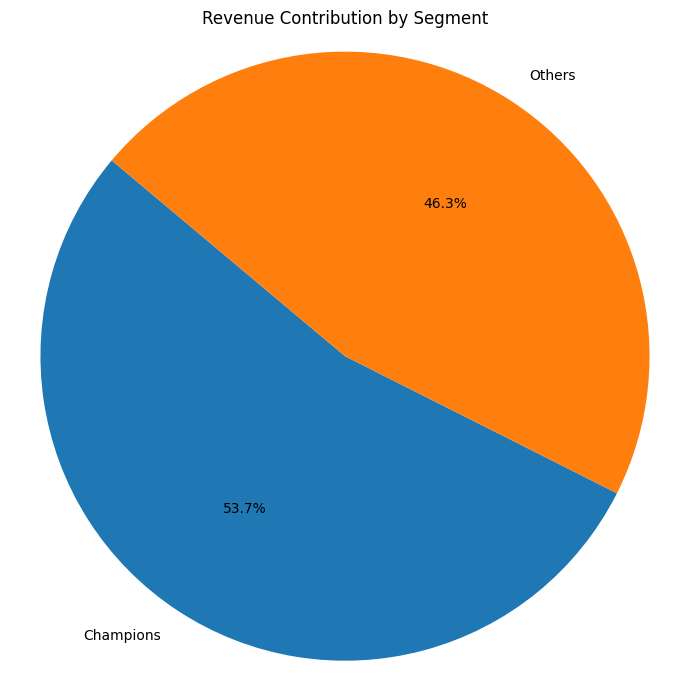

In [41]:
segment_revenue = rfm.groupby('Segment')['Monetary'].sum()

fig2, ax2 = plt.subplots(figsize=(7,7))
ax2.pie(segment_revenue, labels=segment_revenue.index, autopct='%1.1f%%', startangle=140)
ax2.set_title('Revenue Contribution by Segment')
ax2.axis('equal')
plt.tight_layout()
plt.show()

### Boxplot: Spending distribution across segments

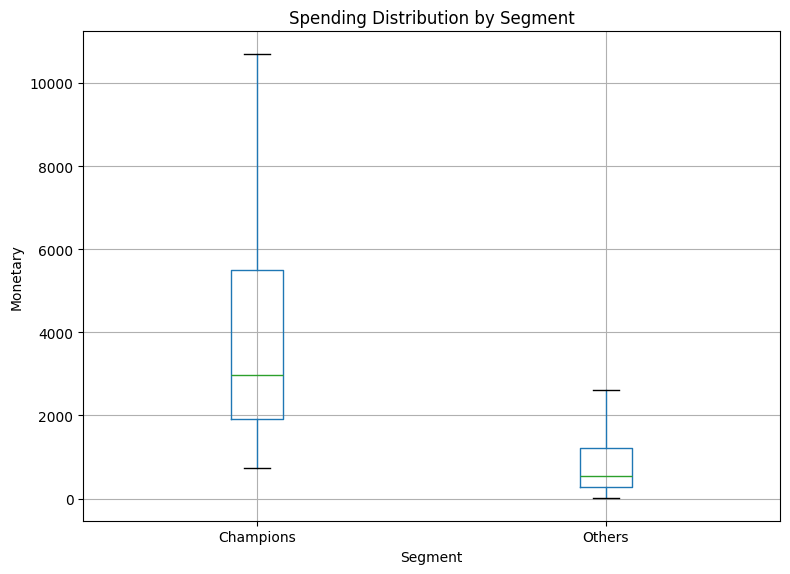

In [42]:
fig3, ax3 = plt.subplots(figsize=(8,6))
rfm.boxplot(column='Monetary', by='Segment', ax=ax3, showfliers=False)
ax3.set_title('Spending Distribution by Segment')
ax3.set_xlabel('Segment')
ax3.set_ylabel('Monetary')
plt.suptitle('')
plt.tight_layout()
plt.show()

## 12. Key Business Insights

### A small percentage of customers contribute a disproportionate share of revenue.

### High-recency and high-frequency customers are critical for revenue stability.

### At-risk customers show declining engagement and require reactivation strategies.

## 13. Business Recommendations

### Implement loyalty and VIP programs for high-value customers.

### Launch targeted re-engagement campaigns for at-risk segments.

### Use personalized offers for frequent buyers to increase lifetime value.